In [1]:
import numpy as np
from itertools import accumulate
from random import random
from matplotlib import pyplot as plt
from icecream import ic

## Reproducible Initialization

If you want to get reproducible results, use `rng` (and restart the kernel); for non-reproducible ones, use `np.random`.

In [2]:
UNIVERSE_SIZE = 1000
NUM_SETS = 100
DENSITY = 0.2

rng = np.random.Generator(np.random.PCG64([UNIVERSE_SIZE, NUM_SETS, int(10_000 * DENSITY)]))

In [3]:
# DON'T EDIT THESE LINES!
SETS = np.random.random((NUM_SETS, UNIVERSE_SIZE)) < DENSITY
for s in range(UNIVERSE_SIZE):
    if not np.any(SETS[:, s]):
        SETS[np.random.randint(NUM_SETS), s] = True
COSTS = np.pow(SETS.sum(axis=1), 1.1)

## Helper Functions

In [4]:
def valid(solution):
    """Checks wether solution is valid (ie. covers all universe)"""
    return np.all(np.logical_or.reduce(SETS[solution]))


def cost(solution):
    """Returns the cost of a solution (to be minimized)"""
    return COSTS[solution].sum()

## Have Fun!

In [5]:
# A dumb solution of "all" sets
solution = np.full(NUM_SETS, True)
valid(solution), cost(solution)

(np.True_, np.float64(291.64361590162724))

In [6]:
# A random solution with random 50% of the sets
solution = rng.random(NUM_SETS) < .5
valid(solution), cost(solution)

(np.False_, np.float64(144.12211594024643))

In [7]:
# # Tweaking functions
# def tweak_single(solution: np.ndarray) -> np.ndarray:
#     new_solution = solution.copy()
#     i = rng.integers(0, NUM_SETS)
#     new_solution[i] = not new_solution[i]
#     return new_solution

def tweak_multiple(solution: np.ndarray, percentage: float = 0.5) -> np.ndarray:
    mask = rng. random(NUM_SETS) < percentage
    if not np.any(mask):
        mask[np.random.randint(NUM_SETS)] = True
    new_solution = np.logical_xor(solution, mask)
    return new_solution

'''
def tweak_multiple(probability, solution):
    new_solution = solution.copy()
    i = None
    while i is None or np.random.random() < probability:
        i = np.random.randint(0, NUM_SETS)
        new_solution[i] = not new_solution[i]
    return new_solution

def tweak_based_on_temperature(temperature: float, solution: np.ndarray) -> np.ndarray:
    if temperature > 0.7:
        # favors exploration, bigger jumps
        return tweak_multiple(0.8, solution)
    elif temperature > 0.3:
        # tradeoff between exploration and exploitation
        return tweak_multiple(0.4, solution)
    else:
        # favors exploitation, smaller jumps
        return tweak_single(solution)'''


'\ndef tweak_multiple(probability, solution):\n    new_solution = solution.copy()\n    i = None\n    while i is None or np.random.random() < probability:\n        i = np.random.randint(0, NUM_SETS)\n        new_solution[i] = not new_solution[i]\n    return new_solution\n\ndef tweak_based_on_temperature(temperature: float, solution: np.ndarray) -> np.ndarray:\n    if temperature > 0.7:\n        # favors exploration, bigger jumps\n        return tweak_multiple(0.8, solution)\n    elif temperature > 0.3:\n        # tradeoff between exploration and exploitation\n        return tweak_multiple(0.4, solution)\n    else:\n        # favors exploitation, smaller jumps\n        return tweak_single(solution)'

In [8]:
def fitness(solution: np.ndarray):
    return (valid(solution), -cost(solution))

In [9]:
def greedy_initialization():
    solution = np.zeros(NUM_SETS, dtype=bool)  
    uncovered_elements = set(range(UNIVERSE_SIZE)) 
    
    while uncovered_elements:
        best_set = None
        best_cover = 0
        for i in range(NUM_SETS):
            if not solution[i]:
                covered = np.sum(SETS[i, list(uncovered_elements)])
                if covered > best_cover:
                    best_cover = covered
                    best_set = i
        solution[best_set] = True
        uncovered_elements -= set(np.where(SETS[best_set])[0]) 
        
    return solution

In [10]:
test_solution = greedy_initialization()
ic(fitness(test_solution))

ic| fitness(test_solution): (np.True_, np.float64(-291.64361590162724))


(np.True_, np.float64(-291.64361590162724))

ic| fitness(solution):

 (np.True_, np.float64(-291.64361590162724))
ic| fitness(solution): (np.False_, np.float64(-22.56803847310483))


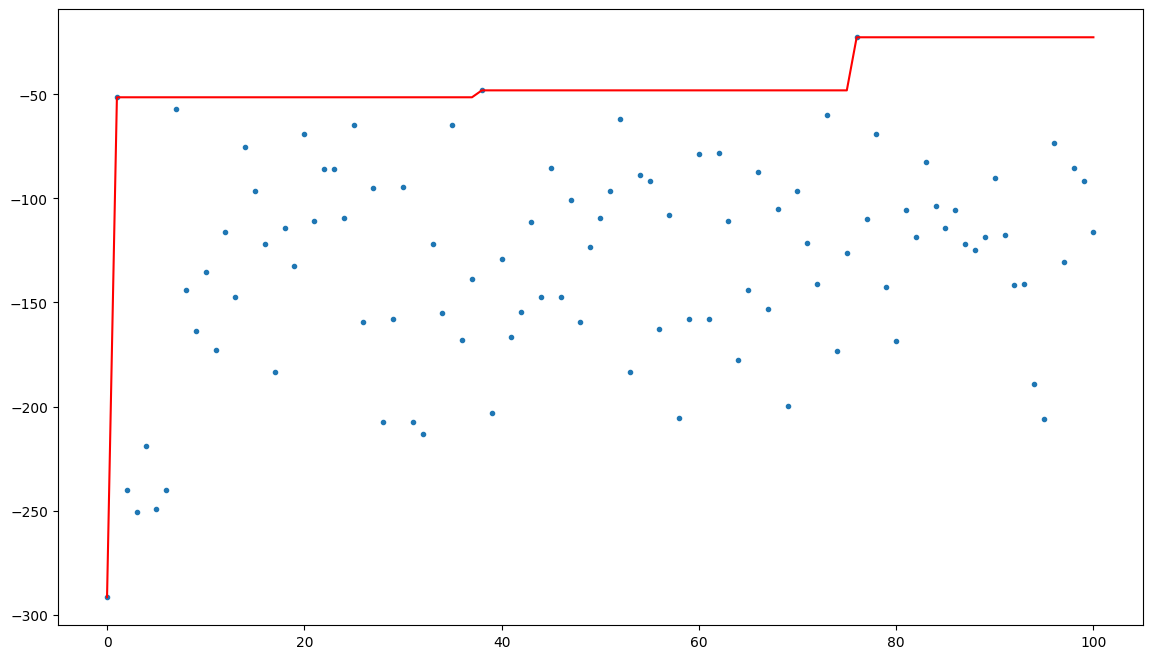

In [11]:
#solution = rng.random(NUM_SETS) < 1
solution = greedy_initialization()
solution_fitness = fitness(solution)
history = [float(solution_fitness[1])]
ic(fitness(solution))

temperature = 0.8
cooling_rate = 0.95

for steps in range(100):
    
    if (temperature > 0.6):
        new_solution = tweak_multiple(solution, 0.8)
    else:
        new_solution = tweak_multiple(solution, 0.4)
    new_fitness = fitness(new_solution)
    
    history.append(float(new_fitness[1]))
    #ic(new_fitness)
        
    if new_fitness > solution_fitness:
        solution = new_solution
        solution_fitness = fitness(solution)
        #ic(new_fitness)
            
    else:
        acceptance_prob = np.exp(-((solution_fitness[1]) - (new_fitness[1])) / temperature)
        if np.random.rand() < acceptance_prob:
            solution = new_solution
            solution_fitness = fitness(solution)
        
    temperature *= cooling_rate

ic(fitness(solution))

plt.figure(figsize=(14,8))
plt.plot(
    range(len(history)),
    list(accumulate(history, max)),
    color="red",
)
_ = plt.scatter(range(len(history)), history, marker=".")

In [12]:
'''solution = rng.random(NUM_SETS) < 0.5
#solution = greedy_initialization()
solution_fitness = fitness(solution)
history = [float(solution_fitness[1])]
ic(fitness(solution))

temperature = 0.8
cooling_rate = 0.95

for steps in range(1000):
    new_solution = tweak_based_on_temperature(temperature, solution)
    new_fitness = fitness(new_solution)
    history.append(float(new_fitness[1]))
        
    if new_fitness > solution_fitness:
        solution = new_solution
        solution_fitness = new_fitness
            
    else:
        acceptance_prob = np.exp(-((solution_fitness[1]) - (new_fitness[1])) / temperature)
        if np.random.rand() < acceptance_prob:
            solution = new_solution
            solution_fitness = new_fitness
        
        temperature *= cooling_rate
        
ic(fitness(solution))

plt.figure(figsize=(14,8))
plt.plot(
    range(len(history)),
    list(accumulate(history, max)),
    color="red",
)
_ = plt.scatter(range(len(history)), history, marker=".")'''

'solution = rng.random(NUM_SETS) < 0.5\n#solution = greedy_initialization()\nsolution_fitness = fitness(solution)\nhistory = [float(solution_fitness[1])]\nic(fitness(solution))\n\ntemperature = 0.8\ncooling_rate = 0.95\n\nfor steps in range(1000):\n    new_solution = tweak_based_on_temperature(temperature, solution)\n    new_fitness = fitness(new_solution)\n    history.append(float(new_fitness[1]))\n        \n    if new_fitness > solution_fitness:\n        solution = new_solution\n        solution_fitness = new_fitness\n            \n    else:\n        acceptance_prob = np.exp(-((solution_fitness[1]) - (new_fitness[1])) / temperature)\n        if np.random.rand() < acceptance_prob:\n            solution = new_solution\n            solution_fitness = new_fitness\n        \n        temperature *= cooling_rate\n        \nic(fitness(solution))\n\nplt.figure(figsize=(14,8))\nplt.plot(\n    range(len(history)),\n    list(accumulate(history, max)),\n    color="red",\n)\n_ = plt.scatter(range(